In [ ]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import skgstat as skg

from sklearn.linear_model import LinearRegression
from sklearn import cluster

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [ ]:
#load okQuakes files
quak = pd.read_csv('okQuakes.csv')
quak.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,1973-03-17T07:43:05.500Z,36.087,-106.168,6.0,4.5,mb,NaN,NaN,NaN,NaN,...,2014-11-06T23:21:10.078Z,New Mexico,earthquake,NaN,NaN,NaN,NaN,reviewed,us,us
1,1973-05-25T14:40:13.900Z,33.917,-90.775,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2014-11-06T23:21:12.859Z,Mississippi,earthquake,NaN,NaN,NaN,NaN,reviewed,s,us
2,1973-09-19T13:28:20.500Z,37.160,-104.594,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2014-11-06T23:21:20.295Z,Colorado,earthquake,NaN,NaN,NaN,NaN,reviewed,us,us
3,1973-09-23T03:58:54.900Z,37.148,-104.571,5.0,4.2,mb,NaN,NaN,NaN,NaN,...,2014-11-06T23:21:20.346Z,Colorado,earthquake,NaN,NaN,NaN,NaN,reviewed,us,us
4,1974-02-15T13:33:49.200Z,36.500,-100.693,24.0,4.5,mb,NaN,NaN,NaN,NaN,...,2014-11-06T23:21:22.859Z,Oklahoma,earthquake,NaN,NaN,NaN,NaN,reviewed,us,us


**A: Exploratory Data Analytics**

In [ ]:
# select seismic event around cheroke
quak_cheo = quak[(quak['longitude']>=-98.5)&(quak['longitude']<=-97.5)&
                      (quak['latitude']>=36.5)&(quak['latitude']<=37.0)]
quak_cheo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2119 entries, 640 to 13953
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             2119 non-null   object 
 1   latitude         2119 non-null   float64
 2   longitude        2119 non-null   float64
 3   depth            2119 non-null   float64
 4   mag              2119 non-null   float64
 5   magType          2119 non-null   object 
 6   nst              120 non-null    float64
 7   gap              1969 non-null   float64
 8   dmin             187 non-null    float64
 9   rms              2103 non-null   float64
 10  net              2119 non-null   object 
 11  id               2119 non-null   object 
 12  updated          2119 non-null   object 
 13  place            2119 non-null   object 
 14  type             2119 non-null   object 
 15  horizontalError  1841 non-null   float64
 16  depthError       2102 non-null   float64
 17  magError   

In [ ]:
# finction to visualize missing value
def get_percentage_nan_values(data, thresh=20, color='black', edgecolor='black', width=15, height=3):
    """
    visualize the percentage of missing values in each columns
    SOURCE: https://www.kaggle.com/amiiiney/price-prediction-regularization-stacking
    """
    
    plt.figure(figsize=(width,height))
    percentage=(data.isnull().mean())*100
    percentage.sort_values(ascending=False).plot.bar(color=color, edgecolor=edgecolor)
    plt.axhline(y=thresh, color='r', linestyle='-')
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+12.5, f'Columns with more than {thresh}% missing values', fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, f'Columns with less than {thresh} missing values', fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight ='bold')
    
    return plt.show()

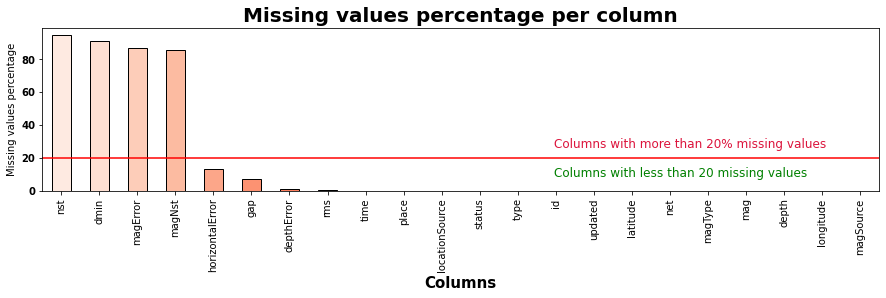

In [ ]:
# show percentage and distribution missing values per columns
get_percentage_nan_values(quak_cheo, 20, color=sns.color_palette('Reds',15))

In [ ]:
# drop columns with more than 20% of missing value
quak_cheo = quak_cheo.dropna(thresh=len(quak_cheo)*0.8, axis=1)
# replace missing value by mean columns
quak_cheo = quak_cheo.fillna(quak_cheo.mean(numeric_only=True))

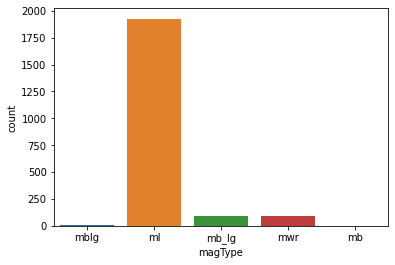

In [ ]:
# used countplot to see the dominant category for magType
sns.countplot(x='magType',data=quak_cheo)
plt.show()

In [ ]:
# replace nan value in 'magType' by the dominant category: 'ml'
quak_cheo['magType'] = quak_cheo['magType'].replace(np.nan,'ml')
quak_cheo.tail()

,time,latitude,longitude,depth,mag,magType,gap,rms,net,id,updated,place,type,horizontalError,depthError,status,locationSource,magSource
13909,2016-09-17T06:08:08.600Z,36.8582,-98.3362,2.46,3.2,mb_lg,82.0,0.13,us,us10006qd2,2016-09-17T17:42:38.991Z,"11km N of Cherokee, Oklahoma",earthquake,1.1,4.9,reviewed,us,us
13910,2016-09-17T06:18:53.990Z,36.7001,-97.7376,2.79,2.9,mb_lg,44.0,0.09,us,us10006qd4,2016-09-17T12:34:12.700Z,"11km S of Medford, Oklahoma",earthquake,1.0,4.6,reviewed,us,us
13948,2016-09-20T04:59:11.140Z,36.9246,-97.8946,2.62,3.9,mwr,18.0,0.46,us,us10006qzl,2016-09-20T19:15:48.944Z,"19km NW of Medford, Oklahoma",earthquake,0.8,5.7,reviewed,us,us
13952,2016-09-20T17:31:48.380Z,36.9393,-97.8960,2.32,3.0,mb_lg,37.0,0.18,us,us10006r59,2016-09-20T17:43:43.040Z,"20km NW of Medford, Oklahoma",earthquake,1.0,3.7,reviewed,us,us
13953,2016-09-20T17:45:59.920Z,36.9405,-97.9063,7.20,2.5,mb_lg,39.0,0.35,us,us10006r5b,2016-09-20T19:48:57.396Z,"21km NW of Medford, Oklahoma",earthquake,1.0,3.4,reviewed,us,us


Text(0.5, 1.05, 'correlations between numerical variables')

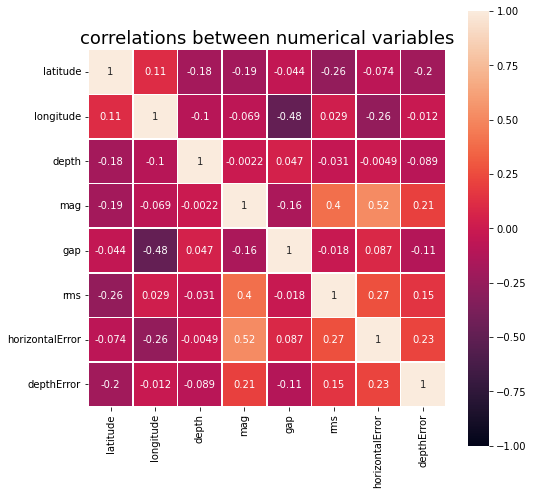

In [ ]:
corr = quak_cheo.corr(method='pearson')

fig, axes = plt.subplots(1,figsize=(8,8))
ax0 = plt.subplot(1,1,1)
sns.heatmap(corr,annot=True,linewidths=.5, annot_kws={"size": 10},vmin=-1.0, vmax=1.0,square=True,cbar=True)
ax0.set_title('correlations between numerical variables',size=18,y=1.05)

**create box plots for IQR**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Ver

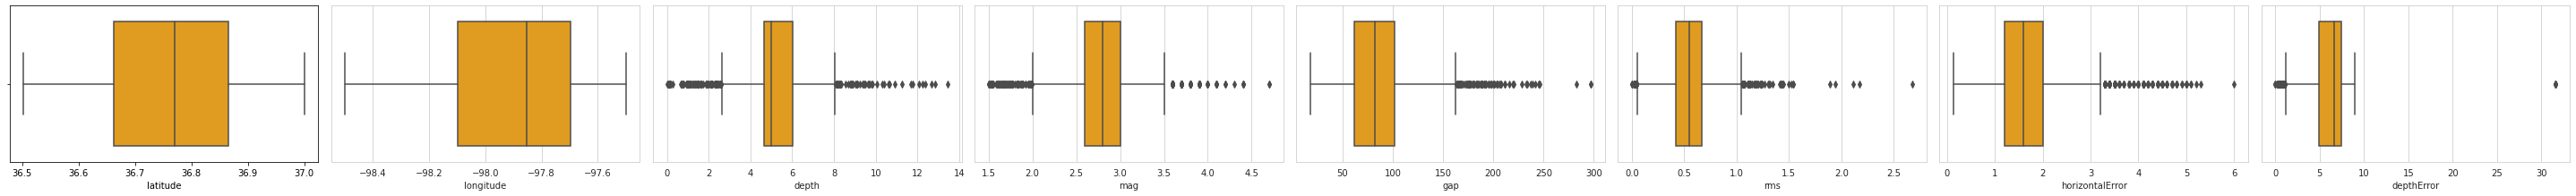

In [ ]:
box_cheo=quak_cheo[['latitude','longitude','depth','mag','gap','rms','horizontalError','depthError',]]

l = box_cheo.columns.values
number_of_columns=12
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(5*number_of_columns,3*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(box_cheo[l[i]],color='orange',orient='v')
    plt.tight_layout()

**skewness**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

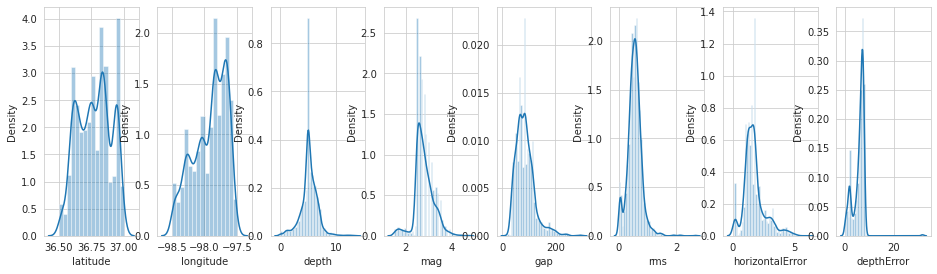

In [ ]:
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(box_cheo[l[i]],kde=True) 

In [ ]:
print('## variance of data')
print(box_cheo.var())
print('#################################')
print('## mean of data')
print(box_cheo.mean())

## variance of data
latitude              0.015625
longitude             0.064156
depth                 2.263037
mag                   0.167595
gap                1251.823707
rms                   0.058217
horizontalError       0.751977
depthError            6.237955
dtype: float64
#################################
## mean of data
latitude           36.773318
longitude         -97.915306
depth               5.198469
mag                 2.808112
gap                85.256018
rms                 0.551797
horizontalError     1.754318
depthError          5.794291
dtype: float64


**cross-variograms**

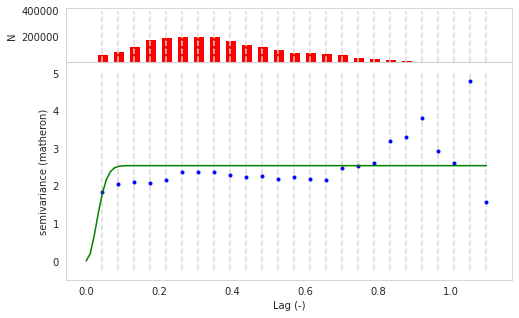

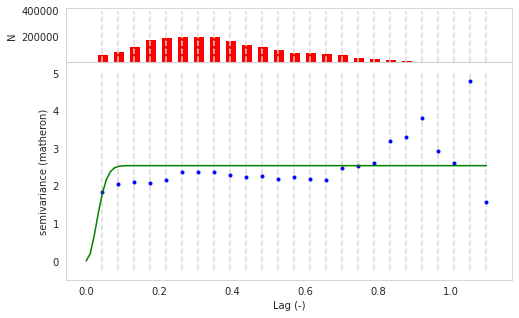

In [ ]:

Vg = skg.Variogram(box_cheo[['latitude','longitude']].values, box_cheo['depth'].values,  normalize=False, n_lags=25, maxlag=90, model='gaussian')

Vg.plot()

In [ ]:
#load injection well
inj_well = pd.read_csv('InjectionWells.csv')
inj_well.head()

,API#,Operator,Operator ID,WellType,WellName,WellNumber,OrderNumbers,Approval Date,County,Sec,...,Rng,QQQQ,LAT,LONG,PSI,BBLS,ZONE,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,3.500300e+09,PHOENIX PETROCORP INC,19499.0,2R,SE EUREKA UNIT-TUCKER #1,21,133856.0,9/6/1977,ALFALFA,13,...,10W,C-SE SE,36.900324,-98.21826,"2,500",300,CHEROKEE,NaN,NaN,NaN
1,3.500300e+09,CHAMPLIN EXPLORATION INC,4030.0,2R,CHRISTENSEN,1,470258.0,11/27/2002,ALFALFA,21,...,09W,C-NW NW,36.896636,-98.17772,"2,400","1,000",RED FORK,NaN,NaN,NaN
2,3.500321e+09,LINN OPERATING INC,22182.0,2R,NE CHEROKEE UNIT,85,329426.0,8/19/1988,ALFALFA,24,...,11W,SE NE,36.806113,-98.32584,"1,050","1,000",RED FORK,NaN,NaN,NaN
3,3.500321e+09,SANDRIDGE EXPLORATION & PRODUCTION LLC,22281.0,2R,VELMA,2-19,281652.0,7/11/1985,ALFALFA,19,...,10W,SW NE NE SW,36.888589,-98.31853,"3,152","1,000",RED FORK,NaN,NaN,NaN
4,3.500321e+09,CHAMPLIN EXPLORATION INC,4030.0,2R,GRAY,1A,470257.0,11/27/2002,ALFALFA,20,...,09W,SE SW NW,36.892128,-98.19462,"1,000","2,400",RED FORK,NaN,NaN,NaN


In [ ]:
# select seismic event around cheroke
inj_well_cheo = inj_well[(inj_well['LONG']>=-98.5)&(inj_well['LONG']<=-97.5)&
                      (inj_well['LAT']>=36.5)&(inj_well['LAT']<=37.0)]
inj_well_cheo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313 entries, 0 to 11096
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   API#           313 non-null    float64
 1   Operator       313 non-null    object 
 2   Operator ID    313 non-null    float64
 3   WellType       313 non-null    object 
 4   WellName       313 non-null    object 
 5   WellNumber     313 non-null    object 
 6   OrderNumbers   313 non-null    float64
 7   Approval Date  313 non-null    object 
 8   County         313 non-null    object 
 9   Sec            313 non-null    object 
 10  Twp            313 non-null    object 
 11  Rng            313 non-null    object 
 12  QQQQ           313 non-null    object 
 13  LAT            313 non-null    float64
 14  LONG           313 non-null    float64
 15  PSI            312 non-null    object 
 16  BBLS           312 non-null    object 
 17  ZONE           313 non-null    object 
 18  Unnamed:

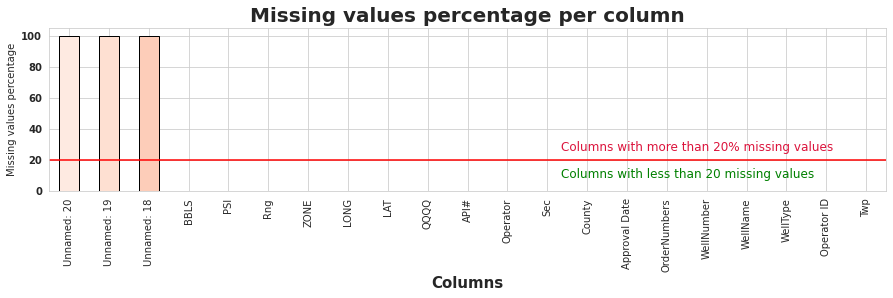

In [ ]:
get_percentage_nan_values(inj_well_cheo, 20, color=sns.color_palette('Reds',15))

In [ ]:
#drop column has missing value more thn 20%
inj_well_cheo = inj_well_cheo.dropna(thresh=len(inj_well_cheo)*0.8, axis=1)
#replace missing value with mean
inj_well_cheo = inj_well_cheo.fillna(inj_well_cheo.mean(numeric_only=True))

In [ ]:
#convert string into number
inj_well_cheo['WellType']= inj_well_cheo['WellType'].astype('category').cat.codes
inj_well_cheo['BBLS']= inj_well_cheo['BBLS'].astype('category').cat.codes
inj_well_cheo['PSI']= inj_well_cheo['PSI'].astype('category').cat.codes

Text(0.5, 1.05, 'correlations between numerical variables')

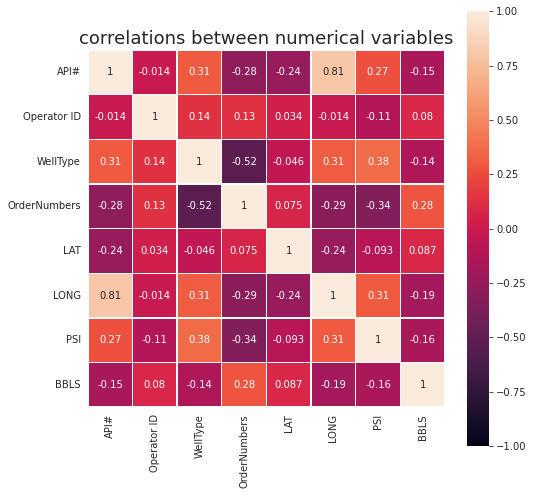

In [ ]:
corr = inj_well_cheo.corr(method='pearson')

fig, axes = plt.subplots(1,figsize=(8,8))
ax0 = plt.subplot(1,1,1)
sns.heatmap(corr,annot=True,linewidths=.5, annot_kws={"size": 10},vmin=-1.0, vmax=1.0,square=True,cbar=True)
ax0.set_title('correlations between numerical variables',size=18,y=1.05)

In [ ]:
inj_well_cheo_box = inj_well_cheo[['PSI','BBLS','WellType','LAT','LONG','OrderNumbers']]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Ver

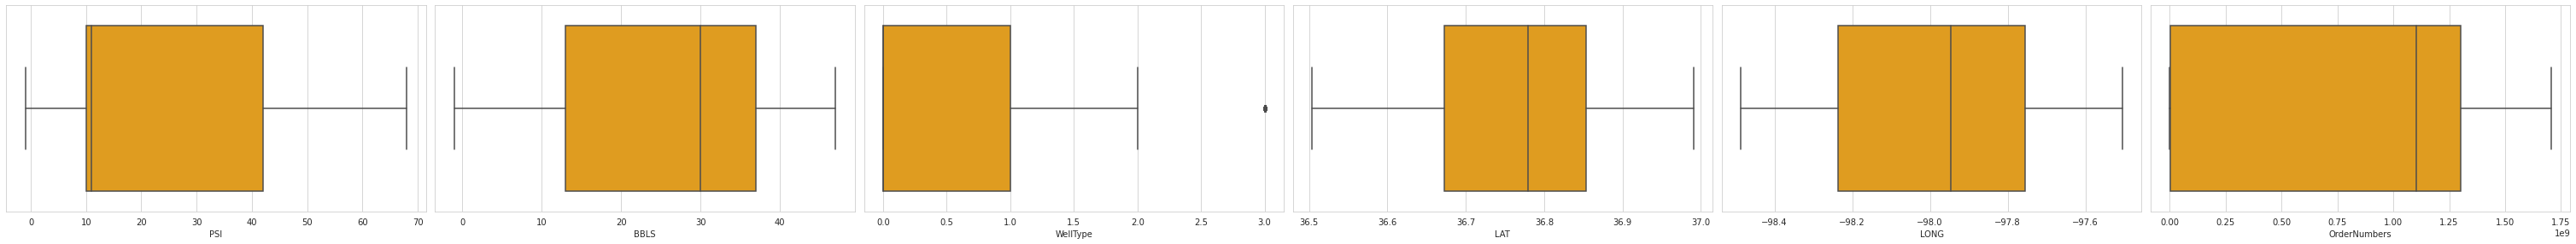

In [ ]:
l = inj_well_cheo_box.columns.values
number_of_columns=6
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(7*number_of_columns,4*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(inj_well_cheo_box[l[i]],color='orange',orient='v')
    plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

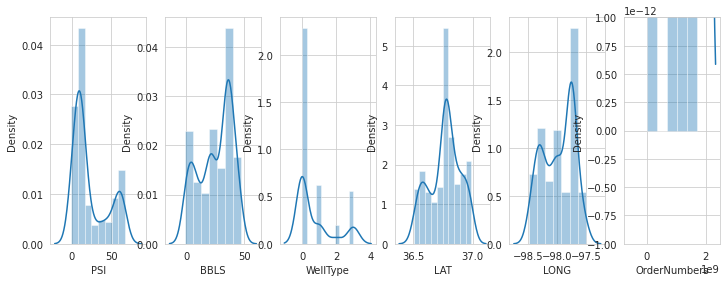

In [ ]:
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(inj_well_cheo_box[l[i]],kde=True)

In [ ]:
print('## variance of data####################')
print(inj_well_cheo_box.var())
print('## mean of data########################')
print(inj_well_cheo_box.mean())

## variance of data####################
PSI             4.854211e+02
BBLS            2.044265e+02
WellType        1.226018e+00
LAT             1.663291e-02
LONG            7.192469e-02
OrderNumbers    4.298433e+17
dtype: float64
## mean of data########################
PSI             2.312141e+01
BBLS            2.525240e+01
WellType        7.380192e-01
LAT             3.676721e+01
LONG           -9.797669e+01
OrderNumbers    7.072993e+08
dtype: float64


**B: Regression Analysis**

In [ ]:
quak_cheo['time'] = pd.to_datetime(quak_cheo['time'])

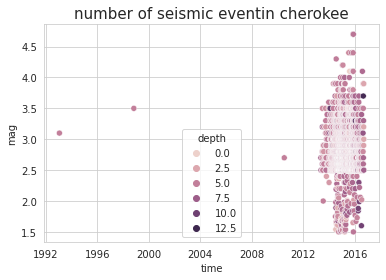

In [ ]:
# Selected earthquakes
ax1 = sns.scatterplot(x =quak_cheo['time'], y=quak_cheo['mag'], hue =quak_cheo['depth'])


# set title
plt.title('number of seismic eventin cherokee',size=15)
plt.show()

In [ ]:
model = LinearRegression()
quak_cheo['datetim'] = np.arange(len(quak_cheo.index))

X=quak_cheo[['datetim']]
Y=quak_cheo['mag']
model.fit(X, Y)

LinearRegression()

In [ ]:
print('intercept:', model.intercept_)

print('slope:', model.coef_)

intercept: 2.783275481492694
slope: [2.34531026e-05]


In [ ]:
print('coefficient of determination:',model.score(X, Y))

coefficient of determination: 0.0012286418857649917


**C: Unsupervised Learning (30):**
elbow plot

> Indented block



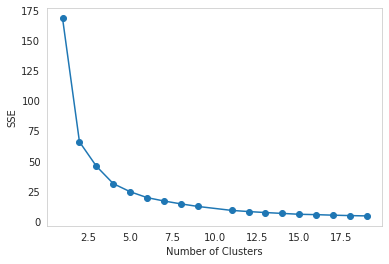

In [ ]:
quak_cheo_clus = quak_cheo[['latitude','longitude']]
numClusters = [1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19]
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(quak_cheo_clus)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE,'-o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.grid()
plt.show()

In [ ]:
# create 4 clusters and assign cluster id 
k_means_meq = cluster.KMeans(n_clusters=4, random_state=1)
k_means_meq.fit(quak_cheo_clus) 

labels_q = k_means_meq.labels_

centroids_q = k_means_meq.cluster_centers_
df_label = pd.DataFrame(labels_q, index=quak_cheo_clus.index, columns=['Cluster ID'])
df_centroid = pd.DataFrame(centroids_q,columns=['latitude','longitude'])

quak_cheo = pd.concat([quak_cheo,df_label],axis=1)

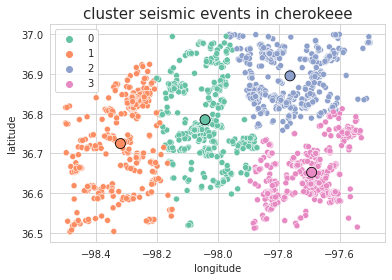

In [ ]:
qualitative_colors = sns.color_palette("Set2", 4)
# Selected earthquakes
ax = sns.scatterplot(x = quak_cheo['longitude'], y= quak_cheo['latitude'],hue = quak_cheo['Cluster ID'],
                      palette = qualitative_colors,legend= False)
# plot centroid
ax = sns.scatterplot(x = df_centroid['longitude'], y= df_centroid['latitude'],
                      hue = df_centroid.index, palette = qualitative_colors,s=100,edgecolor = 'k')

# set title
ax.set_title('cluster seismic events in cherokeee',size=15)
plt.show()

In [ ]:
inj_well_cheo_cls =inj_well_cheo[['LAT','LONG']]

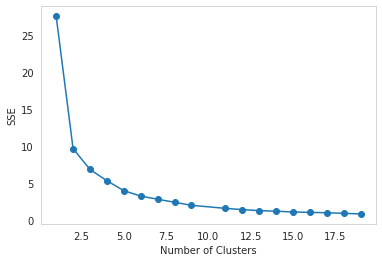

In [ ]:
numClusters = [1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19]
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(inj_well_cheo_cls)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE,'-o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.grid()
plt.show()

In [ ]:
# create 4 clusters and assign cluster id to inj_well_cheo
k_means_meq = cluster.KMeans(n_clusters=4, random_state=1)
k_means_meq.fit(inj_well_cheo_cls) 
labels = k_means_meq.labels_

centroids = k_means_meq.cluster_centers_

df_label = pd.DataFrame(labels, index=inj_well_cheo_cls.index, columns=['Cluster ID'])

df_centroid = pd.DataFrame(centroids,columns=['LAT','LONG'])

inj_well_cheo = pd.concat([inj_well_cheo,df_label],axis=1)
inj_well_cheo.head()

,API#,Operator,Operator ID,WellType,WellName,WellNumber,OrderNumbers,Approval Date,County,Sec,Twp,Rng,QQQQ,LAT,LONG,PSI,BBLS,ZONE,Cluster ID
0,3.500300e+09,PHOENIX PETROCORP INC,19499.0,1,SE EUREKA UNIT-TUCKER #1,21,133856.0,9/6/1977,ALFALFA,13,28N,10W,C-SE SE,36.900324,-98.21826,19,25,CHEROKEE,0
1,3.500300e+09,CHAMPLIN EXPLORATION INC,4030.0,1,CHRISTENSEN,1,470258.0,11/27/2002,ALFALFA,21,28N,09W,C-NW NW,36.896636,-98.17772,16,0,RED FORK,0
2,3.500321e+09,LINN OPERATING INC,22182.0,1,NE CHEROKEE UNIT,85,329426.0,8/19/1988,ALFALFA,24,27N,11W,SE NE,36.806113,-98.32584,2,0,RED FORK,0
3,3.500321e+09,SANDRIDGE EXPLORATION & PRODUCTION LLC,22281.0,1,VELMA,2-19,281652.0,7/11/1985,ALFALFA,19,28N,10W,SW NE NE SW,36.888589,-98.31853,53,0,RED FORK,0
4,3.500321e+09,CHAMPLIN EXPLORATION INC,4030.0,1,GRAY,1A,470257.0,11/27/2002,ALFALFA,20,28N,09W,SE SW NW,36.892128,-98.19462,1,16,RED FORK,0


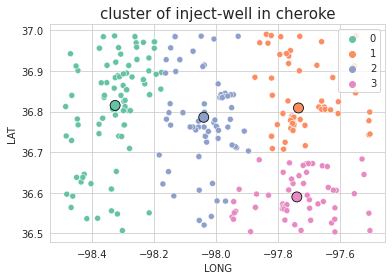

In [ ]:
qualitative_colors = sns.color_palette("Set2", 4)
# Selected earthquakes
ax = sns.scatterplot(x = inj_well_cheo['LONG'], y= inj_well_cheo['LAT'],hue = inj_well_cheo['Cluster ID'],
                      palette = qualitative_colors,legend= False)
# plot centroid
ax = sns.scatterplot(x = df_centroid['LONG'], y= df_centroid['LAT'],
                      hue = df_centroid.index, palette = qualitative_colors,s=100,edgecolor = 'k')

# set title
ax.set_title('cluster of inject-well in cheroke',size=15)
plt.show()

**D: Supervised Learning**
SVM) for classification of seismicity events using K classes

> Indented block



In [ ]:
X=quak_cheo[['latitude','longitude']]
Y=quak_cheo['Cluster ID']

In [ ]:
x_train, x_test,y_train, y_test = train_test_split(X,Y, test_size=0.2)

In [ ]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(x_train, y_train)

SVC(kernel='linear')

In [ ]:
#make confusion matrix for svm
y_pred = svclassifier.predict(x_test)
print(confusion_matrix(y_test,y_pred))

[[ 85   0   4   0]
 [  0  94   0   0]
 [  0   0 129   0]
 [  0   0   3 109]]


In [ ]:
#performe cross validation
cross_val_score(SVC(gamma='auto'), X, Y,cv=3)

array([0.98585573, 0.95892351, 0.98441926])

In [ ]:
def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

**know we perfrome classification on injection well**

In [ ]:
x=inj_well_cheo[['LONG','LAT']]
y=inj_well_cheo['Cluster ID']

In [ ]:
x_train, x_test,y_train, y_test = train_test_split(x,y, test_size=0.2)

In [ ]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(x_train, y_train)
#make confusion matrix for svm
y_pred = svclassifier.predict(x_test)
print(confusion_matrix(y_test,y_pred))

[[22  0  0  0]
 [ 0 17  0  0]
 [ 3  0 11  0]
 [ 0  3  2  5]]


In [ ]:
#performe cross validation
cross_val_score(SVC(gamma='auto'), x,y,cv=3)

array([0.9047619 , 0.93269231, 0.88461538])

**now we use random forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=40)

In [ ]:
rf.fit(x_train, y_train)
rf.score(x_test, y_test)

1.0

In [ ]:
y_pred = rf.predict(x_test)
print(confusion_matrix(y_test,y_pred))

[[22  0  0  0]
 [ 0 17  0  0]
 [ 0  0 14  0]
 [ 0  0  0 10]]


In [ ]:
#perform k-fold cross validation
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=3)

scores_rf = []


for train_index, test_index in folds.split(x,y):
    train_X, test_X = x.iloc[train_index],x.iloc[train_index]
    train_y, test_y = y.iloc[train_index], y.iloc[train_index]
    scores_rf.append(get_score(RandomForestClassifier(n_estimators=40), train_X, test_X, train_y, test_y))

print(scores_rf)

[1.0, 1.0, 1.0]


**Summary:**
we see with number of earthquak with time increase in cherokee
and if we talk about ML frame work we see random forest perform well as compare to svm. it gave us 100% accuracy which is best one
